In [35]:
import os
import time
import pandas as pd
from pytrends.request import TrendReq
from pytrends.exceptions import TooManyRequestsError
from requests.exceptions import RequestException
import seaborn as sns
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Creating the data

In [27]:
def fetch_weekly_interest(keyword, timeframe='2021-06-01 2024-06-01', retries=5):
    pytrends = TrendReq(hl='en-GB', tz=0)
    for attempt in range(retries):
        try:
            pytrends.build_payload([keyword], geo='GB', timeframe=timeframe)
            interest_over_time = pytrends.interest_over_time()
            if 'isPartial' in interest_over_time.columns:
                interest_over_time = interest_over_time.drop(columns=['isPartial'])
            return interest_over_time
        except RequestException as e:
            print(f"Request failed (attempt {attempt + 1}/{retries}): {e}. Retrying after a delay...")
            time.sleep(60)  # Sleep for 60 seconds before retrying
    print(f"Failed to fetch data for GB after {retries} attempts.")
    return pd.DataFrame()  # Return an empty DataFrame if all retries fail

keyword = "Monzo"
timeframe = "2021-01-01 2024-09-01"  # Specific date range

df = fetch_weekly_interest(keyword, timeframe)
df.reset_index(inplace=True)

df

,date,Monzo
0,2020-12-27,26
1,2021-01-03,30
2,2021-01-10,28
3,2021-01-17,30
4,2021-01-24,30
...,...,...
188,2024-08-04,60
189,2024-08-11,67
190,2024-08-18,61
191,2024-08-25,63


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    193 non-null    datetime64[ns]
 1   Monzo   193 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.1 KB


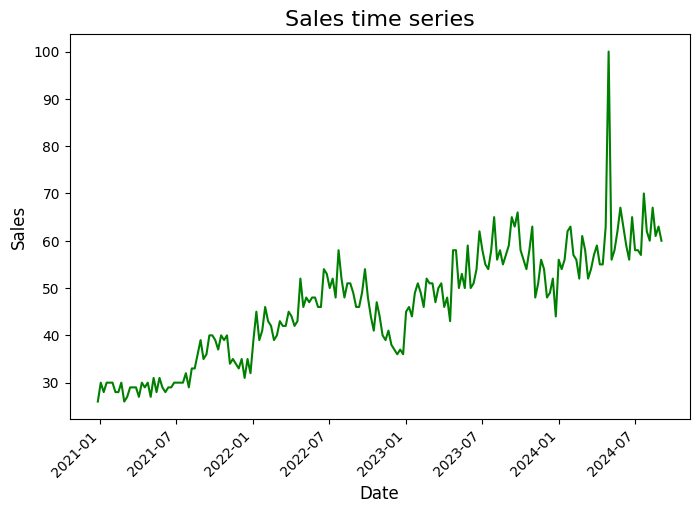

In [29]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df["date"], y=df["Monzo"], color="green")

plt.title('Sales time series', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

# Preparing the data

In [36]:
os.environ['NIXTLA_ID_AS_COL'] = '1'

df["unique_id"] = 1
df = df.rename(columns={"date": "ds", "Monzo": "y"})
df

,ds,y,unique_id
0,2020-12-27,26,1
1,2021-01-03,30,1
2,2021-01-10,28,1
3,2021-01-17,30,1
4,2021-01-24,30,1
...,...,...,...
188,2024-08-04,60,1
189,2024-08-11,67,1
190,2024-08-18,61,1
191,2024-08-25,63,1


In [ ]:
# train/test indexs

# EDA

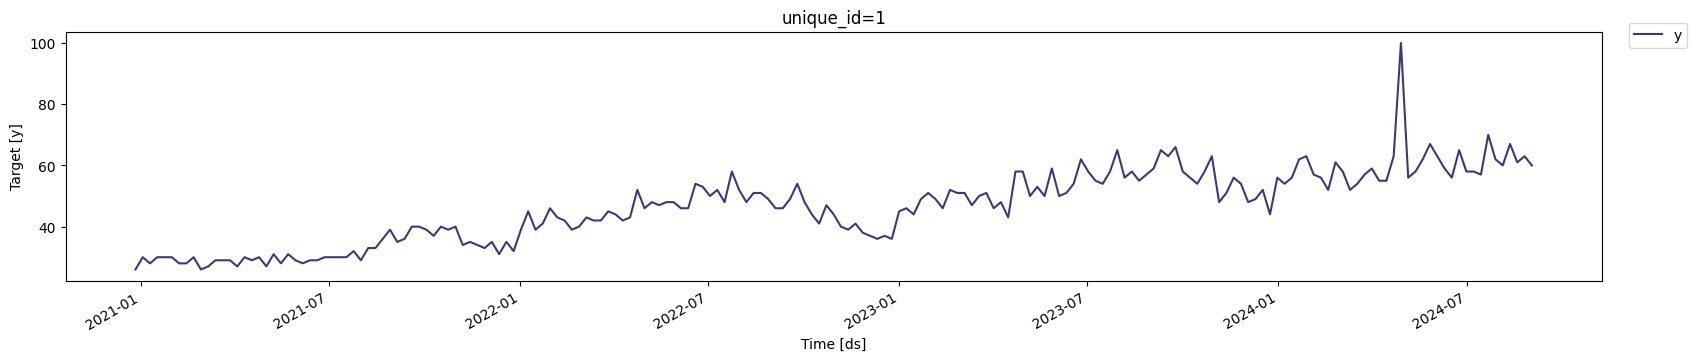

In [31]:
StatsForecast.plot(df)

# Training the model

In [32]:
sf = StatsForecast(
    models=[AutoARIMA(season_length = 12)],
    freq='W',
)

sf.fit(df)

StatsForecast(models=[AutoARIMA])

In [38]:
forecast_df = sf.predict(h=12, level=[90])

forecast_df

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
0,1,2024-09-08,61.833637,53.477802,70.189468
1,1,2024-09-15,61.833637,53.051479,70.615791
2,1,2024-09-22,61.833637,52.644913,71.022354
3,1,2024-09-29,61.833637,52.255592,71.411682
4,1,2024-10-06,61.833637,51.881489,71.785782
5,1,2024-10-13,61.833637,51.520947,72.146324
6,1,2024-10-20,61.833637,51.172592,72.494682
7,1,2024-10-27,61.833637,50.835266,72.832008
8,1,2024-11-03,61.833637,50.507980,73.159294
9,1,2024-11-10,61.833637,50.189892,73.477379


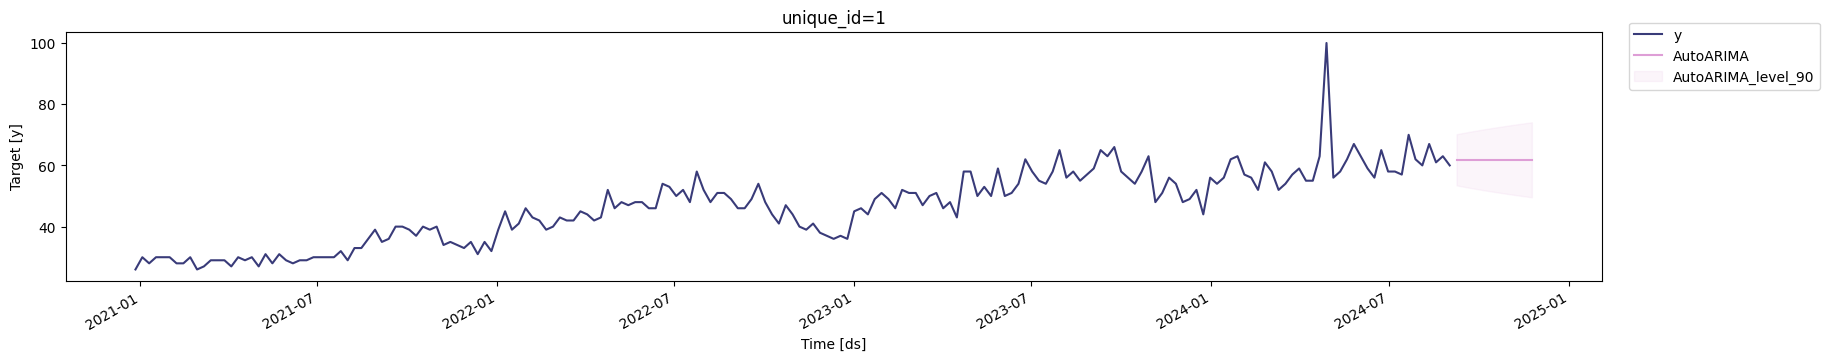

In [39]:
sf.plot(df, forecast_df, level=[90])

# Evaluating the model